# A factory for hybrid ground-truth generation


6/11/2018 Vidrio Technologies

## Preamble

Import a few modules.

In [1]:
import os
import sys
homedir = os.getenv("USERPROFILE") if sys.platform=='win32' else os.getenv("HOME")

import os.path as op

import matplotlib.pyplot as plt
import numpy as np

factory_dir = op.join(homedir, "repos", "hybridfactory")
if not factory_dir in sys.path:
    sys.path.insert(0, factory_dir)
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
import factory.data.dataset
import factory.data.annotation
import factory.generate.generator
import factory.probes
import factory.validate.comparison

In [3]:
%matplotlib notebook

## Construct a probe

Use one of our helper functions...

<IPython.core.display.Javascript object>


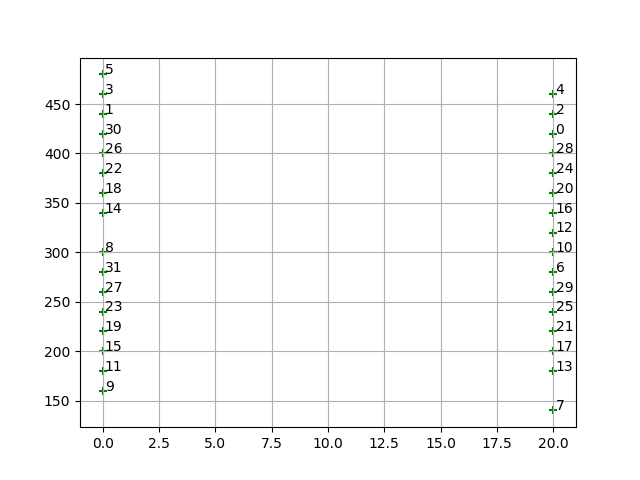

In [4]:
probe = factory.probes.eMouse()  # synthetic eMouse probe from KiloSort
fig, ax = probe.display(marker='+', color='g')

... or roll your own:

In [5]:
channel_map = np.hstack((np.arange(64), np.array([111, 110, 109, 108, 106, 107, 104, 105, 102, 103, 100, 101, 98,
                                                  99, 96, 97, 80, 81, 82, 83, 85, 84, 87, 86, 89, 88, 91, 90, 93,
                                                  92, 95, 94, 65, 64, 67, 66, 69, 68, 71, 70, 73, 72, 75, 74, 76,
                                                  77, 78, 79, 126, 127, 124, 125, 122, 123, 120, 121, 118, 119, 116,
                                                  117, 115, 114, 113, 112]), np.arange(128, 256)))

# reference channels
refchans = np.hstack((np.arange(64), np.arange(128, 256)))
connected = ~np.isin(channel_map, refchans)

# physical location of each channel on the probe
xcoords = np.hstack((np.repeat(np.nan, 64),
                     np.repeat([0, 250], 32), np.repeat(np.nan, 128)))
ycoords = np.hstack((np.repeat(np.nan, 64),
                     np.tile(25 * np.arange(32), 2), np.repeat(np.nan, 128)))
channel_positions = np.hstack((xcoords[:, np.newaxis], ycoords[:, np.newaxis]))

custom = factory.probes.custom_probe(channel_map=channel_map, connected=connected,
                                     channel_positions=channel_positions)

<IPython.core.display.Javascript object>


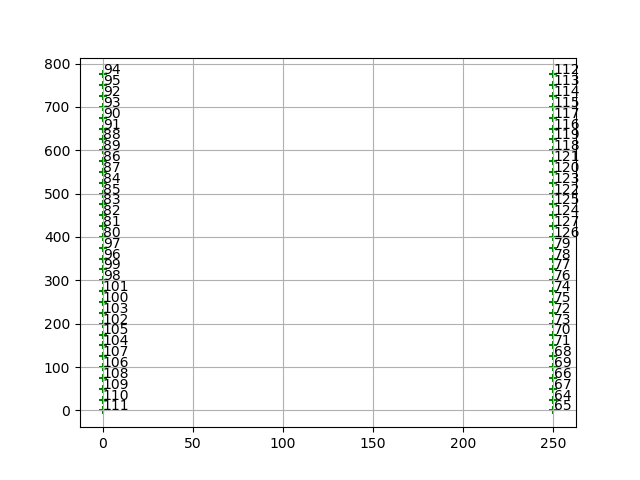

In [6]:
fig, ax = custom.display(marker='+', color='g')

## Load a data set with annotations

### Supported raw data formats
- SpikeGL\[X\]

### Supported annotation formats
- KiloSort (`rez.mat`)
- Phy (`*.npy`)
- JRCLUST (`*_jrc.mat`, `*_spk(raw|wav|fet).jrc`)

In [7]:
eMouse_dir = op.join(homedir, "Documents", "Data", "eMouse")
raw_file = op.join(eMouse_dir, "sim_binary.dat")
output_type = "phy"

source = factory.data.dataset.new_annotated_dataset(raw_file, dtype=np.int16, sample_rate=25000, probe=probe)

## View and query annotations

In [8]:
source.annotations.head(10)

,timestep,cluster,template
0,128,30,30
1,171,10,10
2,410,32,32
3,530,13,13
4,532,49,49
5,610,36,36
6,616,20,20
7,646,33,33
8,775,4,4
9,898,23,23


In [9]:
# how many events do we have in each cluster?
source.annotations.groupby("cluster").count().head(10)

,timestep,template
cluster,,
0,9013,9013
1,7307,7307
2,1623,1623
3,4146,4146
4,12510,12510
6,3446,3446
7,592,592
8,5746,5746
9,6512,6512


## Visualize units

In [10]:
k, unit = 0, 7  # select a cluster
t = source.annotations[source.annotations.cluster == unit].timestep.values[k]  # get the first timestep

source.open_raw()  # open a memmap onto the raw data file
uw = source.unit_windows(unit, samples_before=40, samples_after=40)  # open windows onto all events in this cluster
region = uw[:, :, k]  #  select the first of these

In [11]:
def plot_region(region):
    plt.figure(figsize=(5, 5))

    plt.imshow(region[probe.connected_channels()], "coolwarm", aspect="auto", interpolation="nearest",
               extent=(t - 40, t + 41, 34, 0))    
    plt.colorbar()
    plt.tight_layout()

<IPython.core.display.Javascript object>


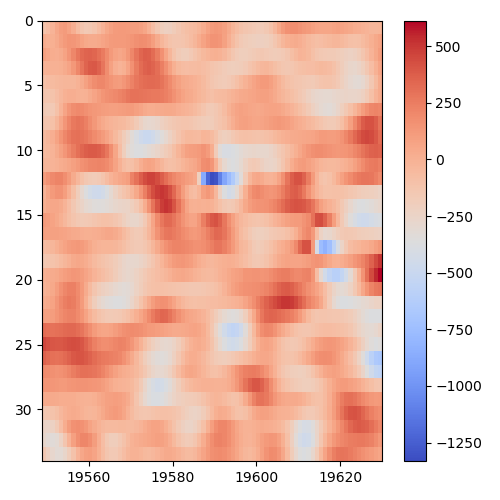

In [12]:
plot_region(region)

## Now construct a HybridDataSet and Generator from source

In [13]:
hybrid = factory.data.dataset.new_hybrid_dataset(source=source,
                                                 output_directory=op.join(eMouse_dir, "hybrid_output"), copy=True)
generator = factory.generate.generator.SVDGenerator(dataset=hybrid, event_threshold=-60,
                                                    samples_before=40, samples_after=40)

The HybridDataSet will look like the source at first...

In [14]:
(hybrid.annotations == source.annotations).all()

timestep    True
cluster     True
template    True
dtype: bool

...but it'll also have artificial units

In [15]:
hybrid.artificial_units

,timestep,true_unit,new_unit,center_channel


(there aren't any yet)

## Let's generate a new unit

In [16]:
hybrid.open_raw("r+")
# what channels does this unit occur on?
unit_channels = hybrid.unit_channels(unit=unit, threshold=-60, samples_before=40, samples_after=40)
# shift them to some other location
shifted_channels = generator.shift_channels(channels=unit_channels, shift_factor=None)
# generate some synthetic firing times at a rate of 10 Hz
firing_times = generator.synthetic_firing_times(firing_rate=10)

In [17]:
def plot_shifted_channels(probe, unit_channels, shifted_channels):
    fig, ax = probe.display(marker='*', color='g')

    x, y = probe.channel_coordinates(unit_channels).T
    ax.scatter(x, y, color='r', marker='8')

    sx, sy = probe.channel_coordinates(shifted_channels).T
    ax.scatter(sx, sy, color='b', marker='x')

<IPython.core.display.Javascript object>


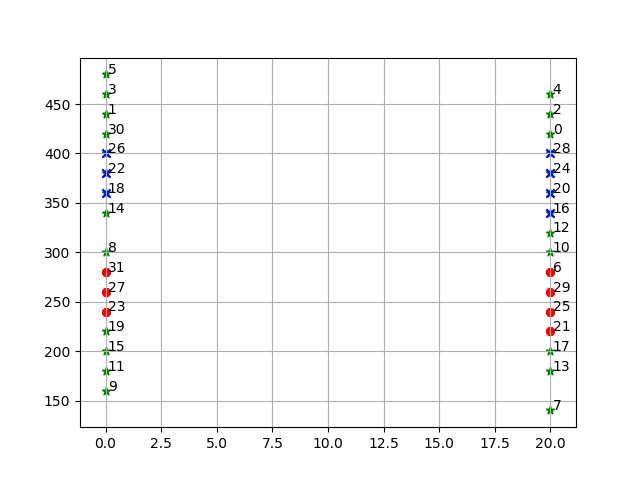

In [18]:
# display true channels as red octagons, shifted channels as blue Xs
plot_shifted_channels(probe, unit_channels, shifted_channels)

## Actually construct the new events

In [19]:
# generate events from a low-rank decomposition-reconstruction
artificial_events = generator.construct_events(unit=unit, num_singular_values=7, num_events=firing_times.size)
# scale factors are uniformly sampled from the interval [scale_min, scale_max]
artificial_events = generator.scale_events(events=artificial_events, scale_min=0.66, scale_max=1.5)

In [20]:
def plot_artificial_events(artificial_events):
    a, b = np.random.choice(artificial_events.shape[2], size=2, replace=False)
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(artificial_events[:, :, 0].T)
    
    plt.subplot(2,1,2)
    plt.plot(artificial_events[:, :, -1].T)

<IPython.core.display.Javascript object>


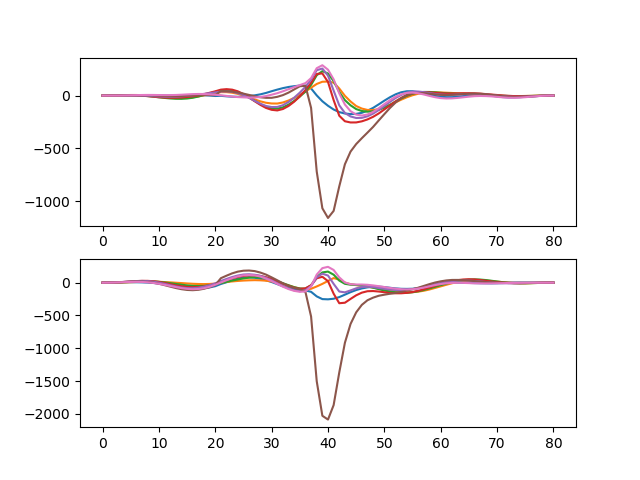

In [21]:
plot_artificial_events(artificial_events)

## Now insert them into the data

In [22]:
generator.insert_unit(events=artificial_events, event_times=firing_times, channels=shifted_channels, true_unit=unit)

Close the data set and reopen as read-only.

In [23]:
hybrid.close_raw()
hybrid.open_raw("r")

## Check out the results

In [24]:
hybrid.artificial_units.head(10)

,timestep,true_unit,new_unit,center_channel
0,2510,7,64,5
1,5031,7,64,5
2,7556,7,64,5
3,10009,7,64,5
4,12478,7,64,5
5,15132,7,64,5
6,17536,7,64,5
7,20046,7,64,5
8,22610,7,64,5
9,25052,7,64,5


In [26]:
t = hybrid.artificial_units.timestep[0]

source.open_raw()
before = source.read_roi(channels=np.arange(probe.num_channels), samples=np.arange(t-40, t+41))

artificial_windows = hybrid.unit_windows(64, samples_before=40, samples_after=40)
after = artificial_windows[:, :, 0]

In [25]:
def plot_before_after_regions(probe, before, after):
    plt.figure()

    vmin, vmax = min(before.min(), after.min()), max(before.max(), after.max())
    plt.subplot(1,2,1)
    plt.imshow(before[probe.connected_channels()], "coolwarm", aspect="auto", interpolation="nearest",
               extent=(t - 40, t + 41, 34, 0), vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("before")

    plt.subplot(1,2,2)
    plt.imshow(after[probe.connected_channels()], "coolwarm", aspect="auto", interpolation="nearest",
               extent=(t - 40, t + 41, 34, 0), vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("after")

    plt.tight_layout()

<IPython.core.display.Javascript object>


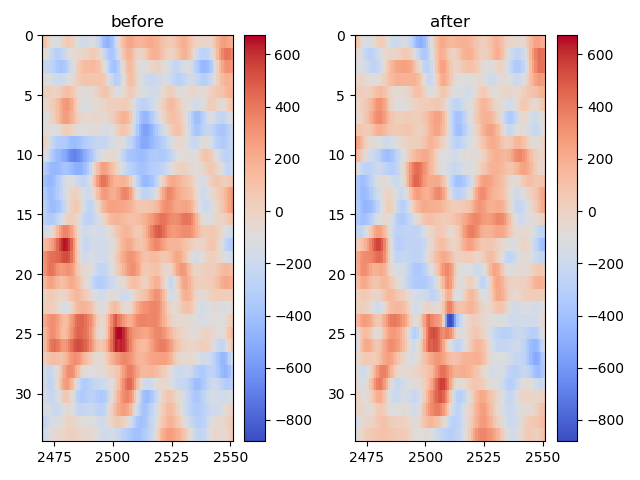

In [27]:
plot_before_after_regions(probe, before, after)

In [29]:
def plot_before_after_waveforms(before, after, channels):

    plt.figure()
    
    ymin = min(before[channels].min(), after[channels].min()) - 50
    ymax = max(before[channels].max(), after[channels].max()) + 50

    plt.subplot(2,1,1)
    plt.plot(before[channels].T)
    plt.ylim((ymin, ymax))
    plt.title("before")


    plt.subplot(2,1,2)
    plt.plot(after[channels].T)
    plt.ylim((ymin, ymax))
    plt.title("after")

    plt.tight_layout()

<IPython.core.display.Javascript object>


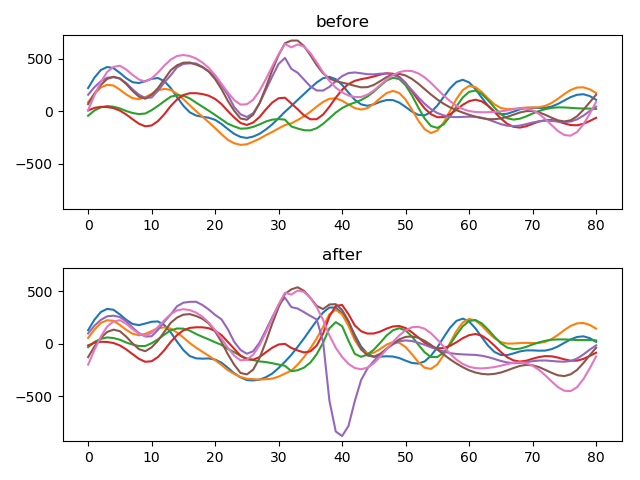

In [30]:
hybrid_channels = hybrid.unit_channels(64, threshold=-60, samples_before=40, samples_after=40)
plot_before_after_waveforms(before, after, hybrid_channels)

## Save our new unit to CSV/NumPy binary file.

In [31]:
hybrid.export_artificial_units(op.join(eMouse_dir, "hybrid_output", "artificial_units.csv"))
hybrid.export_ground_truth_matrix(op.join(eMouse_dir, "hybrid_output", "firings_true.npy"))
hybrid.close_raw()

## ...after sorting...

In [32]:
hybrid_file = op.join(eMouse_dir, "hybrid_output", "sim_binary.GT.dat")
hybrid_sorted = factory.data.dataset.new_annotated_dataset(hybrid_file, dtype=np.int16, sample_rate=25000,
                                                           probe=probe)
firing_matrix = factory.data.annotation.load_ground_truth_matrix(op.dirname(hybrid_file))

In [33]:
tpc = factory.validate.comparison.new_template_pair_comparison(source, hybrid_sorted, firing_matrix)
tpc.load_templates(eMouse_dir, op.join(eMouse_dir, "hybrid_output"))

In [52]:
from imp import reload
reload(factory.validate.comparison)
tpc = factory.validate.comparison.new_template_pair_comparison(source, hybrid_sorted, firing_matrix)
tpc.load_templates(eMouse_dir, op.join(eMouse_dir, "hybrid_output"))

In [71]:
best_templates, event_jitters, event_scores = tpc.score_hybrid_output(how="corr")

In [80]:
def plot_shifted_templates(true_template, shifted_template, best_match):
    plt.figure()
    plt.subplot(3,1,1)
    plt.imshow(true_template.T, "coolwarm", interpolation="nearest", aspect="auto")
    plt.title("True (source) template)")
    
    plt.subplot(3,1,2)
    plt.imshow(shifted_template.T, "coolwarm", interpolation="nearest", aspect="auto")
    plt.title("Shifted (source) template)")
    
    plt.subplot(3,1,3)
    plt.imshow(best_match.T, "coolwarm", interpolation="nearest", aspect="auto")
    plt.title("Best match (hybrid) template)")
    
    plt.tight_layout()

<IPython.core.display.Javascript object>


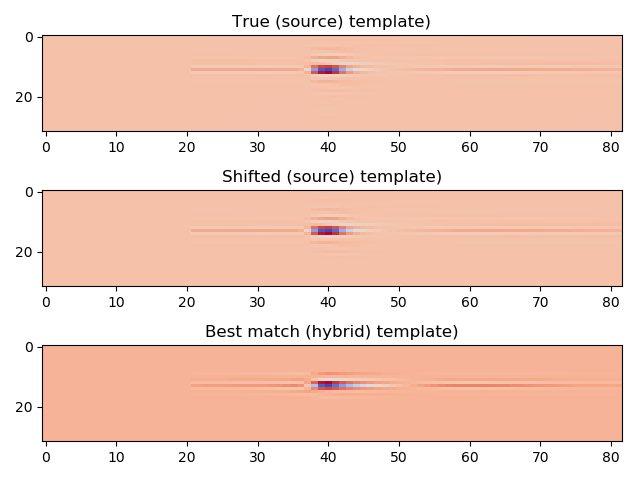

In [81]:
# shift the true template to where we inserted the artificial unit
sc = probe.channel_map[hybrid_sorted.artificial_units.center_channel[event_scores.argmax()]]
shifted_template = tpc.shift_template(tpc.true_templates[7], shifted_center=sc)

best_match=tpc.hybrid_templates[best_templates[event_scores.argmax()]]
plot_shifted_templates(tpc.true_templates[7], shifted_template, best_match)

In [86]:
factory.validate.comparison.build_confusion_matrix(true_labels=hybrid_sorted.artificial_units.true_unit.values,
                                                   hybrid_labels=best_templates)

hybrid label,5,9,49,18,6,3,30,28,0,4,...,58,7,15,23,39,47,42,12,35,62
true label,,,,,,,,,,,,,,,,,,,,,
7,714,704,645,611,585,568,545,496,382,369,...,39,39,38,37,27,2,1,1,1,1
